In [ ]:
# make connection to google drive to access data
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# set up directory paths to image files
train_path = "/content/drive/My Drive/C-NMC/training_data"
test_path = "/content/drive/My Drive/C-NMC/testing_data/C-NMC_test_final_phase_data"
val_path = "/content/drive/My Drive/C-NMC/validation_data/C-NMC_test_prelim_phase_data"

In [ ]:
# install tensorflow module
!pip install tensorflow numpy

In [ ]:
# import relevant image, data analysis and deep learning libraries
import os
import numpy as np
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers, Model, Input

%matplotlib inline

In [ ]:
healthy_imgs = [] # initialize list to store healthy images
for file in os.listdir(train_path):
  for file2 in os.listdir(os.path.join(train_path, file, "hem")):
    img_path = os.path.join(train_path, file, "hem", file2) # build full image file path

    # load
    img = Image.open(img_path).convert("RGB") # open image and convert to rgb format
    img = img.resize((224, 224)) # resize to 224x224
    healthy_imgs.append(np.array(img, dtype=np.float32)) # convert image to numpy array and append to list

# normalize
healthy_imgs = (np.array(healthy_imgs) / 127.5) - 1.0 # scale pixel values to range [-1.0, 1.0]

In [ ]:
# length of total healthy images with shape
healthy_imgs.shape

(3389, 224, 224, 3)

In [ ]:
cancer_imgs = [] # list to hold all loaded cancer image arrays
i = 0 # initialize image counter

# iterate over each subdirectory
for file in os.listdir(train_path):
    if i >= 3000: # stop once 3000 images are collected
        break
    for file2 in os.listdir(os.path.join(train_path, file, "all")): # iterate through cancer imgaes
        img_path = os.path.join(train_path, file, "all", file2) # construct full path

        # load
        img = Image.open(img_path).convert("RGB") # open and convert to RGB format
        img = img.resize((224, 224)) # resize image to 224x224
        cancer_imgs.append(np.array(img, dtype=np.float32)) # convert to numpy and append
        i += 1 # increment count

# normalize
cancer_imgs = (np.array(cancer_imgs) / 127.5) - 1.0 # scale pixel values to [-1, 1] range

In [ ]:
# length of total cancer images with shape
cancer_imgs.shape

(4815, 224, 224, 3)

In [ ]:
# hyperparameters & setup
batch_size = 32 # number of samples per batch
codings_size = 500 # dimensionality of the noise vector for the generator
num_classes = 2 # binary classification: 0 = healthy, 1 = leukemic
epochs = 250 # total number of training epochs

In [ ]:
# conditional generator model
def make_generator():
  # noise input
  noise_input = Input(shape=(codings_size,), name="noise_input")
  # label input (integer value)
  label_input = Input(shape=(1,), name="label_input")

  # embed label to vector of size 50
  label_embedding = layers.Embedding(num_classes, 50, input_length=1)(label_input)
  label_embedding = layers.Flatten()(label_embedding)

  # concatenate noise and embedded label
  merged_input = layers.Concatenate()([noise_input, label_embedding])

  # project combined vector and reshape
  x = layers.Dense(7 * 7 * 128, use_bias=False)(merged_input)
  x = layers.BatchNormalization()(x)
  x = layers.ReLU()(x)
  x = layers.Reshape((7, 7, 128))(x) # shape: (7, 7, 128)

  # upsampling to reach target resolution (224x224)
  x = layers.Conv2DTranspose(128, kernel_size=5, strides=2, padding="same", use_bias=False)(x)
  x = layers.BatchNormalization()(x)
  x = layers.LeakyReLU()(x)

  x = layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding="same", use_bias=False)(x)
  x = layers.BatchNormalization()(x)
  x = layers.LeakyReLU()(x)

  x = layers.Conv2DTranspose(64, kernel_size=5, strides=2, padding="same", use_bias=False)(x)
  x = layers.BatchNormalization()(x)
  x = layers.LeakyReLU()(x)

  x = layers.Conv2DTranspose(32, kernel_size=5, strides=2, padding="same", use_bias=False)(x)
  x = layers.BatchNormalization()(x)
  x = layers.LeakyReLU()(x)

  x = layers.Conv2DTranspose(32, kernel_size=5, strides=2, padding="same", use_bias=False)(x)
  x = layers.BatchNormalization()(x)
  x = layers.LeakyReLU()(x)

  # output: 224x224x3 image with tanh activation
  output_img = layers.Conv2DTranspose(3, kernel_size=5, strides=1, padding="same", activation="tanh")(x)

  model = Model(inputs=[noise_input, label_input], outputs=output_img, name="cgan_generator")
  return model

In [ ]:
generator = make_generator() # instantiate conditional generator
generator.summary() # print model architecture summary

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "cgan_generator"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ label_input         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 1, 50)     │        100 │ label_input[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ noise_input         │ (None, 500)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 50)        │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 550)       │          0 │ noise_input[0][0… │
│ (Concatenate)       │                   │            │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 6272)      │  3,449,600 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 6272)      │     25,088 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 6272)      │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 7, 7, 128) │          0 │ re_lu[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose    │ (None, 14, 14,    │    409,600 │ reshape[0][0]     │
│ (Conv2DTranspose)   │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 14, 14,    │        512 │ conv2d_transpose… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 14, 14,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_1  │ (None, 28, 28,    │    204,800 │ leaky_re_lu[0][0] │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        256 │ conv2d_transpose… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 28, 28,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_2  │ (None, 56, 56,    │    102,400 │ leaky_re_lu_1[0]… │
│ (Conv2DTranspose)   │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 56,    │        256 │ conv2d_transpose… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_2       │ (None, 56, 56,    │          0 │ batch_normalizat… │
│ (LeakyReLU)         │ 64)               │            │                 

 Total params: 4,272,071 (16.30 MB)

 Trainable params: 4,258,887 (16.25 MB)

 Non-trainable params: 13,184 (51.50 KB)

In [ ]:
def make_discriminator():
  image_input = Input(shape=(224, 224, 3), name="image_input") # image input
  label_input = Input(shape=(1,), name="label_input") # label input

  label_embedding = layers.Embedding(num_classes, 50, input_length=1)(label_input) # embed label
  label_embedding = layers.Flatten()(label_embedding) # flatten embedding
  label_embedding = layers.Dense(224*224)(label_embedding) # expand to match image resolution
  label_embedding = layers.Reshape((224, 224, 1))(label_embedding) # reshape to spatial map

  merged_input = layers.Concatenate(axis=-1)([image_input, label_embedding]) # combine image and label

  # 112x112
  x = layers.Conv2D(64, kernel_size=4, strides=2, padding="same")(merged_input)
  x = layers.LeakyReLU(alpha=0.2)(x)
  x = layers.Dropout(0.3)(x)

  # 56x56
  x = layers.Conv2D(128, kernel_size=4, strides=2, padding="same")(x)
  x = layers.LeakyReLU(alpha=0.2)(x)
  x = layers.Dropout(0.3)(x)

  # 28x28
  x = layers.Conv2D(256, kernel_size=4, strides=2, padding="same")(x)
  x = layers.LeakyReLU(alpha=0.2)(x)
  x = layers.Dropout(0.3)(x)

  # 14x14
  x = layers.Conv2D(512, kernel_size=4, strides=2, padding="same")(x)
  x = layers.LeakyReLU(alpha=0.2)(x)
  x = layers.Dropout(0.3)(x)

  # 7x7
  x = layers.Conv2D(1024, kernel_size=4, strides=2, padding="same")(x)
  x = layers.LeakyReLU(alpha=0.2)(x)
  x = layers.Dropout(0.3)(x)

  x = layers.Flatten()(x) # flatten for output

  output_prob = layers.Dense(1, activation="sigmoid")(x) # final sigmoid output

  model = Model(inputs=[image_input, label_input], outputs=output_prob, name="cgan_discriminator")
  return model

In [ ]:
discriminator = make_discriminator() # instantiate conditional discriminator
discriminator.summary() # print model architecture summary

/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "cgan_discriminator"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ label_input         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 1, 50)     │        100 │ label_input[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 50)        │          0 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 50176)     │  2,558,976 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ image_input         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 224, 224,  │          0 │ dense_1[0][0]     │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 224, 224,  │          0 │ image_input[0][0… │
│ (Concatenate)       │ 4)                │            │ reshape_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 112, 112,  │      4,160 │ concatenate_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_5       │ (None, 112, 112,  │          0 │ conv2d[0][0]      │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 112, 112,  │          0 │ leaky_re_lu_5[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 56, 56,    │    131,200 │ dropout[0][0]     │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_6       │ (None, 56, 56,    │          0 │ conv2d_1[0][0]    │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 56, 56,    │          0 │ leaky_re_lu_6[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 28, 28,    │    524,544 │ dropout_1[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_7       │ (None, 28, 28,    │          0 │ conv2d_2[0][0]    │
│ (LeakyReLU)         │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 28, 28,    │          0 │ leaky_re_lu_7[0]… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 14, 14,    │  2,097,664 │ dropout_2[0][0]   │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 13,756,453 (52.48 MB)

 Trainable params: 13,756,453 (52.48 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# loss functions
def discriminator_loss(real_output, fake_output): # real labels = 1, fake labels = 0
    real_loss = tf.keras.losses.binary_crossentropy(tf.ones_like(real_output), real_output) # loss for real images
    fake_loss = tf.keras.losses.binary_crossentropy(tf.zeros_like(fake_output), fake_output) # loss for fake images
    return tf.reduce_mean(real_loss) + tf.reduce_mean(fake_loss) # total discriminator loss

def generator_loss(fake_output): # generator wants output to look real (label = 1)
    return tf.reduce_mean(tf.keras.losses.binary_crossentropy(tf.ones_like(fake_output), fake_output)) # generator loss

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5) # optimizer for generator
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.00005, beta_1=0.5, clipvalue=1.0) # optimizer for discriminator with gradient clipping

In [ ]:
# prepare dataset

# create labels for each class
healthy_labels = np.zeros((healthy_imgs.shape[0], 1), dtype=np.int32) # class 0: healthy
cancer_labels  = np.ones((cancer_imgs.shape[0], 1), dtype=np.int32) # class 1: cancer

# combine images and labels
images = np.concatenate((healthy_imgs, cancer_imgs), axis=0)
labels = np.concatenate((healthy_labels, cancer_labels), axis=0)

# shuffle dataset to ensure random distribution
indices = np.random.permutation(len(images))
images = images[indices]
labels = labels[indices]

# print dataset info
print(f"Dataset shape: {images.shape}")
print(f"Labels shape: {labels.shape}")
print(f"Healthy samples: {np.sum(labels == 0)}")
print(f"Cancer samples: {np.sum(labels == 1)}")
print(f"Image value range: [{images.min():.2f}, {images.max():.2f}]")

Dataset shape: (8204, 224, 224, 3)
Labels shape: (8204, 1)
Healthy samples: 3389
Cancer samples: 4815
Image value range: [-1.00, 0.73]


In [ ]:
# create tf.data.Dataset of (image, label) pairs
dataset = tf.data.Dataset.from_tensor_slices((images, labels)) # pair each image with label
dataset = dataset.shuffle(buffer_size=1000).batch(batch_size) # shuffle and batch dataset

In [ ]:
# training step function
@tf.function
def train_step_balanced(images, labels): # one step of conditional GAN training
    batch_size = tf.shape(images)[0] # get dynamic batch size
    noise = tf.random.normal([batch_size, codings_size]) # generate initial noise

    with tf.GradientTape() as disc_tape: # discriminator update
        generated_images = generator([noise, labels], training=True) # generate fake images
        real_output = discriminator([images, labels], training=True) # classify real images
        fake_output = discriminator([generated_images, labels], training=True) # classify fakes
        d_loss = discriminator_loss(real_output, fake_output) # compute discriminator loss

    gradients_of_discriminator = disc_tape.gradient(d_loss, discriminator.trainable_variables) # compute gradients
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables)) # apply update

    g_losses = [] # collect generator losses
    for _ in range(2): # double update for generator
        noise = tf.random.normal([batch_size, codings_size]) # fresh noise
        with tf.GradientTape() as gen_tape:
            generated_images = generator([noise, labels], training=True) # generate new fakes
            fake_output = discriminator([generated_images, labels], training=True) # evaluate
            g_loss = generator_loss(fake_output) # compute generator loss

        gradients_of_generator = gen_tape.gradient(g_loss, generator.trainable_variables) # compute gradients
        generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables)) # apply update
        g_losses.append(g_loss) # record loss

    return d_loss, tf.reduce_mean(g_losses) # return discriminator and average generator loss

Epoch 1/250
Epoch 1, Discriminator Loss: 1.3659, Generator Loss: 0.7066
Epoch 1, Discriminator Loss: 1.3659, Generator Loss: 0.7066


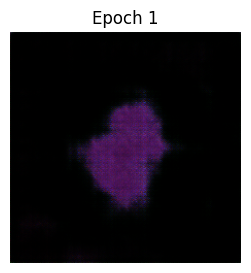

Epoch 2/250
Epoch 3/250
Epoch 4/250
Epoch 5/250
Epoch 6/250
Epoch 7/250
Epoch 8/250
Epoch 9/250
Epoch 10/250
Epoch 11/250
Epoch 11, Discriminator Loss: 1.3912, Generator Loss: 0.7000
Epoch 12/250
Epoch 13/250
Epoch 14/250
Epoch 15/250
Epoch 16/250
Epoch 17/250
Epoch 18/250
Epoch 19/250
Epoch 20/250
Epoch 21/250
Epoch 21, Discriminator Loss: 1.3251, Generator Loss: 0.8183
Epoch 22/250
Epoch 23/250
Epoch 24/250
Epoch 25/250
Epoch 26/250
Epoch 26, Discriminator Loss: 1.3733, Generator Loss: 0.6836


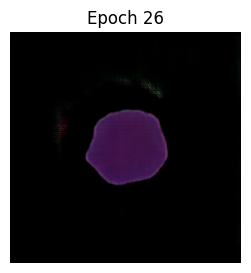

Epoch 27/250
Epoch 28/250
Epoch 29/250
Epoch 30/250
Epoch 31/250
Epoch 31, Discriminator Loss: 1.3823, Generator Loss: 0.7024
Epoch 32/250
Epoch 33/250
Epoch 34/250
Epoch 35/250
Epoch 36/250
Epoch 37/250
Epoch 38/250
Epoch 39/250
Epoch 40/250
Epoch 41/250
Epoch 41, Discriminator Loss: 1.4040, Generator Loss: 0.6927
Epoch 42/250
Epoch 43/250
Epoch 44/250
Epoch 45/250
Epoch 46/250
Epoch 47/250
Epoch 48/250
Epoch 49/250
Epoch 50/250
Epoch 51/250
Epoch 51, Discriminator Loss: 1.3860, Generator Loss: 0.6877
Epoch 51, Discriminator Loss: 1.3860, Generator Loss: 0.6877


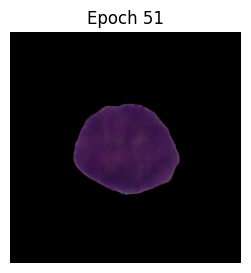

Epoch 52/250
Epoch 53/250
Epoch 54/250
Epoch 55/250
Epoch 56/250
Epoch 57/250
Epoch 58/250
Epoch 59/250
Epoch 60/250
Epoch 61/250
Epoch 61, Discriminator Loss: 1.3855, Generator Loss: 0.6914
Epoch 62/250
Epoch 63/250
Epoch 64/250
Epoch 65/250
Epoch 66/250
Epoch 67/250
Epoch 68/250
Epoch 69/250
Epoch 70/250
Epoch 71/250
Epoch 71, Discriminator Loss: 1.3857, Generator Loss: 0.7154
Epoch 72/250
Epoch 73/250
Epoch 74/250
Epoch 75/250
Epoch 76/250
Epoch 76, Discriminator Loss: 1.3899, Generator Loss: 0.7018


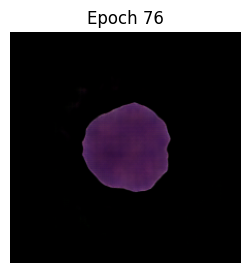

Epoch 77/250
Epoch 78/250
Epoch 79/250
Epoch 80/250
Epoch 81/250
Epoch 81, Discriminator Loss: 1.3918, Generator Loss: 0.7136
Epoch 82/250
Epoch 83/250
Epoch 84/250
Epoch 85/250
Epoch 86/250
Epoch 87/250
Epoch 88/250
Epoch 89/250
Epoch 90/250
Epoch 91/250
Epoch 91, Discriminator Loss: 1.3825, Generator Loss: 0.6939
Epoch 92/250
Epoch 93/250
Epoch 94/250
Epoch 95/250
Epoch 96/250
Epoch 97/250
Epoch 98/250
Epoch 99/250
Epoch 100/250
Epoch 101/250
Epoch 101, Discriminator Loss: 1.3757, Generator Loss: 0.6961
Epoch 101, Discriminator Loss: 1.3757, Generator Loss: 0.6961


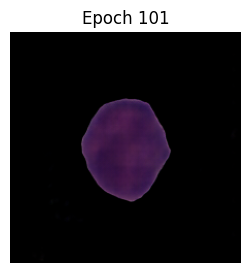

Epoch 102/250
Epoch 103/250
Epoch 104/250
Epoch 105/250
Epoch 106/250
Epoch 107/250
Epoch 108/250
Epoch 109/250
Epoch 110/250
Epoch 111/250
Epoch 111, Discriminator Loss: 1.3880, Generator Loss: 0.6823
Epoch 112/250
Epoch 113/250
Epoch 114/250
Epoch 115/250
Epoch 116/250
Epoch 117/250
Epoch 118/250
Epoch 119/250
Epoch 120/250
Epoch 121/250
Epoch 121, Discriminator Loss: 1.4041, Generator Loss: 0.7114
Epoch 122/250
Epoch 123/250
Epoch 124/250
Epoch 125/250
Epoch 126/250
Epoch 126, Discriminator Loss: 1.4255, Generator Loss: 0.7347


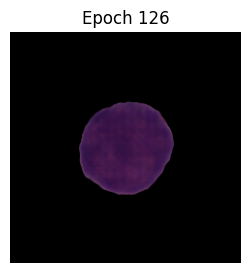

Epoch 127/250
Epoch 128/250
Epoch 129/250
Epoch 130/250
Epoch 131/250
Epoch 131, Discriminator Loss: 1.4910, Generator Loss: 0.7762
Epoch 132/250
Epoch 133/250
Epoch 134/250
Epoch 135/250
Epoch 136/250
Epoch 137/250
Epoch 138/250
Epoch 139/250
Epoch 140/250
Epoch 141/250
Epoch 141, Discriminator Loss: 1.3086, Generator Loss: 0.7335
Epoch 142/250
Epoch 143/250
Epoch 144/250
Epoch 145/250
Epoch 146/250
Epoch 147/250
Epoch 148/250
Epoch 149/250
Epoch 150/250
Epoch 151/250
Epoch 151, Discriminator Loss: 1.4141, Generator Loss: 0.6918
Epoch 151, Discriminator Loss: 1.4141, Generator Loss: 0.6918


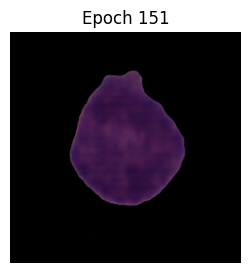

Epoch 152/250
Epoch 153/250
Epoch 154/250
Epoch 155/250
Epoch 156/250
Epoch 157/250
Epoch 158/250
Epoch 159/250
Epoch 160/250
Epoch 161/250
Epoch 161, Discriminator Loss: 1.3778, Generator Loss: 0.7757
Epoch 162/250
Epoch 163/250
Epoch 164/250
Epoch 165/250
Epoch 166/250
Epoch 167/250
Epoch 168/250
Epoch 169/250
Epoch 170/250
Epoch 171/250
Epoch 171, Discriminator Loss: 1.3080, Generator Loss: 0.7601
Epoch 172/250
Epoch 173/250
Epoch 174/250
Epoch 175/250
Epoch 176/250
Epoch 176, Discriminator Loss: 1.0882, Generator Loss: 0.7880


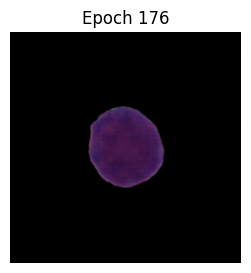

Epoch 177/250
Epoch 178/250
Epoch 179/250
Epoch 180/250
Epoch 181/250


KeyboardInterrupt: 

In [ ]:
# training loop
d_losses, g_losses = [], [] # lists to store losses over epochs

for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    for image_batch, label_batch in dataset: # iterate over dataset
        d_loss, g_loss = train_step_balanced(image_batch, label_batch) # perform training step

    d_losses.append(d_loss) # record discriminator loss
    g_losses.append(g_loss) # record generator loss

    if (epoch) % 10 == 0:
        print(f"Epoch {epoch+1}, Discriminator Loss: {d_loss.numpy():.4f}, Generator Loss: {g_loss.numpy():.4f}")
    if (epoch) % 25 == 0:
        print(f"Epoch {epoch+1}, Discriminator Loss: {d_loss.numpy():.4f}, Generator Loss: {g_loss.numpy():.4f}")

        sample_noise = tf.random.normal([1, codings_size]) # generate noise
        sample_label = np.array([[0]]) # change to 1 to visualize alternate class
        sample_label = tf.convert_to_tensor(sample_label, dtype=tf.int32)
        generated_image = generator([sample_noise, sample_label], training=False)

        plt.figure(figsize=(4,3))
        plt.imshow(generated_image[0, :, :, :] * 0.5 + 0.5) # convert image from [-1, 1] to [0, 1]
        plt.title(f"Epoch {epoch+1}")
        plt.axis("off")
        plt.show()

        # save models and weights
        generator.save(f'/content/drive/MyDrive/cgan_generator_epoch-{epoch}.keras')
        discriminator.save(f'/content/drive/MyDrive/cgan_discriminator_epoch-{epoch}.keras')
        generator.save_weights(f'/content/drive/MyDrive/cgan_generator_weights_epoch-{epoch}.weights.h5')
        discriminator.save_weights(f'/content/drive/MyDrive/cgan_discriminator_weights_epoch-{epoch}.weights.h5')

print("Training Completed!")

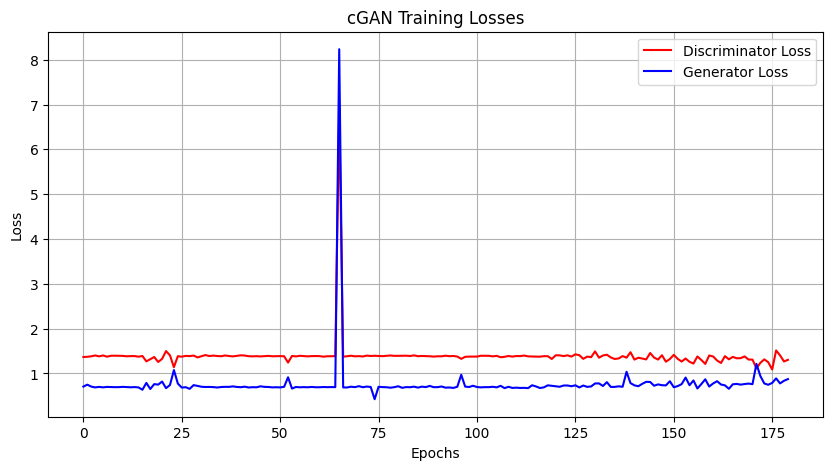

In [ ]:
# plot Loss Curves
plt.figure(figsize=(10, 5))
plt.plot(d_losses, label="Discriminator Loss", color='red') # plot discriminator loss in red
plt.plot(g_losses, label="Generator Loss", color='blue') # plot generator loss in blue
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("cGAN Training Losses")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
generator.save("cgan_generator.keras") # save full generator model
discriminator.save("cgan_discriminator.keras") # save full critic model

In [ ]:
generator.save_weights("cgan_generator_weights.weights.h5") # save only generator weights
discriminator.save_weights("cgan_discriminator_weights.weights.h5") # save only critic weights

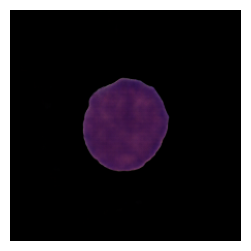

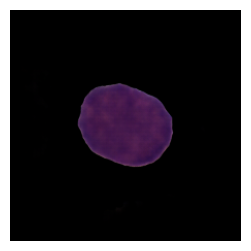

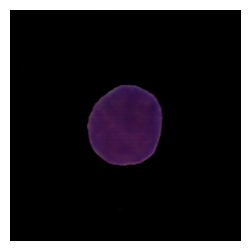

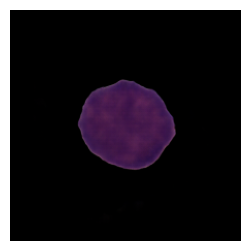

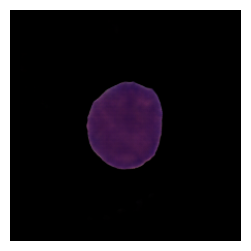

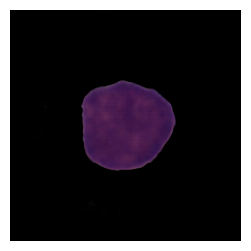

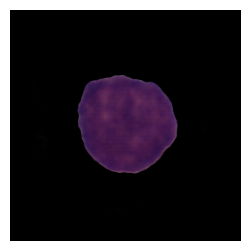

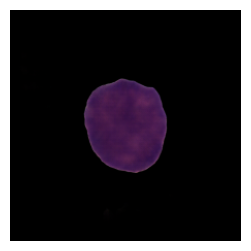

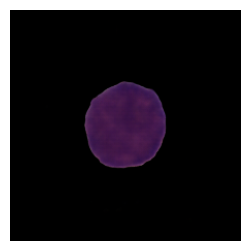

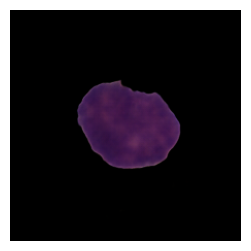

In [ ]:
# loop to plot generated images
for i in range(10):
    sample_noise = tf.random.normal([1, codings_size])
    sample_label = np.array([[0]]) # change to 1 for alternate class.
    sample_label = tf.convert_to_tensor(sample_label, dtype=tf.int32)
    generated_image = generator([sample_noise, sample_label], training=False)

    plt.figure(figsize=(4, 3))
    plt.imshow(generated_image[0, :, :, :] * 0.5 + 0.5) # rescale pixel values
    plt.axis("off")
    plt.show()